# Forecast
***

**Author**: Chus Casado<br>
**Date**: 19-12-2022<br>

**Introduction**:<br>


**Questions**:<br>
* It seems like all the members from the COSMOS ensemble have the same data.
* The ECMWF ensemble forecast hast only 15 timesteps (aprox. 5 days), instead of 10 days.
* The forecasts from DWD and EUD the 2018-06-20 12:00:00 is missing.
* How to remove temporal autocorrelation?

**Tasks to do**:<br>

- [ ] Find how many formal notifications would have been sent.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix, f1_score

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## Stations 

In [2]:
# area threshold
area_threshold = 500

In [3]:
# load table of fixed reporing points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')

# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area_threshold) & (stations.FixedRepPoint == True)
stations_sel = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'DrainingArea.km2.LDD', 'Catchment', 'River', 'EC_Catchments', 'Country code']]

print(f'No. stations:\t{stations_sel.shape[0]}')

No. stations:	2371


In [4]:
# select station
stations_po = stations_sel.loc[stations_sel.Catchment == 'Po'].sort_values('DrainingArea.km2.LDD', ascending=False)
print(f'No. stations:\t{stations_po.shape[0]}')

No. stations:	57


In [5]:
# select downstream station and assign 5 yr return period discharge (Q5)
stn = str(stations_po.index[1])
Q5 = 4000

In [6]:
# estimate Q5 for each station
stations_po['Q5'] = stations_po['DrainingArea.km2.LDD'] * Q5 / stations_po.loc[int(stn), 'DrainingArea.km2.LDD']

In [7]:
stations_po.head()

StationName  LisfloodX  LisfloodY  DrainingArea.km2.LDD  \
station_id                                                               
393         Pontelagoscuro  4447500.0  2422500.0               71175.0   
2791            Borgoforte  4387500.0  2437500.0               63275.0   
834                Boretto  4367500.0  2422500.0               55525.0   
399                Cremona  4322500.0  2447500.0               51075.0   
398               Piacenza  4302500.0  2442500.0               41950.0   

           Catchment River EC_Catchments Country code           Q5  
station_id                                                          
393               Po    Po            Po           IT  4499.407349  
2791              Po    Po            Po           IT  4000.000000  
834               Po    Po            Po           IT  3510.075069  
399               Po    Po            Po           IT  3228.763335  
398               Po    Po            Po           IT  2651.916239

## Reanalysis

In [54]:
stn = '3317'
Q5 = stations_po.loc[int(stn), 'Q5']

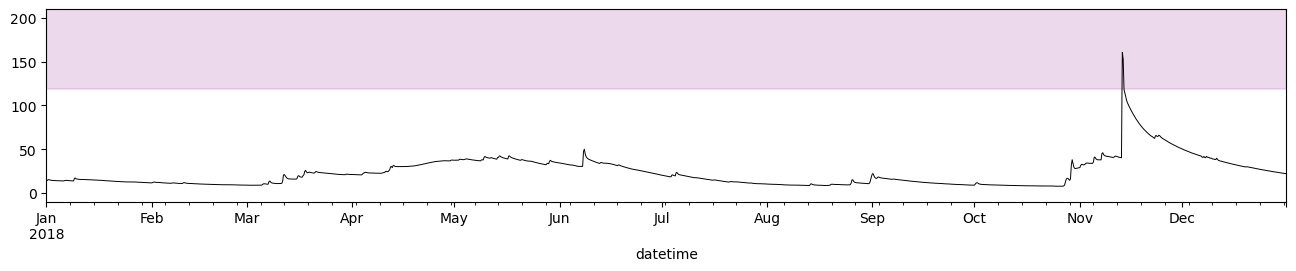

In [55]:
reanalysis = pd.read_csv('../data/CDS/reanalysis/EFAS_reanalysis_2018.csv', parse_dates=True, index_col=0)

fig, ax = plt.subplots(figsize=(16, 2.5))
reanalysis[stn].plot(color='k', lw=.7, ax=ax)
ax.fill_between(reanalysis.index, Q5, 10000, color='purple', alpha=.15)
magnitude = len(str(int(reanalysis[stn].max()))) - 1
ymax = np.ceil(reanalysis[stn].max() / 10**(magnitude)) * 10**magnitude + 10**(magnitude - 1)
ymin = - 10**(magnitude - 1)
ax.set(ylim=(ymin, ymax));

## Forecast

### List available data

In [10]:
models = ['COS', 'DWD', 'EUD', 'EUE']

# list files
files = {model: [] for model in models}
for year in [2018]:
    for month in range(1, 13):    
        # list files
        for model in models:
            files[model] += glob.glob(f'{path_forecast}{model}/{year}/{month:02d}/*.nc')

In [11]:
# count files and check if all are avaible
n_files = pd.Series(data=[len(files[model]) for model in models], index=models)

# list of forecast from the beginning to end of the data
start, end = datetime(2100, 1, 1), datetime(1900, 1, 1)
for model in models:
    st, en = [datetime.strptime(files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = min(st, start)
    end = max(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print(missing)

{'COS': [], 'DWD': [Timestamp('2018-06-20 12:00:00', freq='12H')], 'EUD': [Timestamp('2018-06-20 12:00:00', freq='12H')], 'EUE': []}


### Analysis of one forecast among models

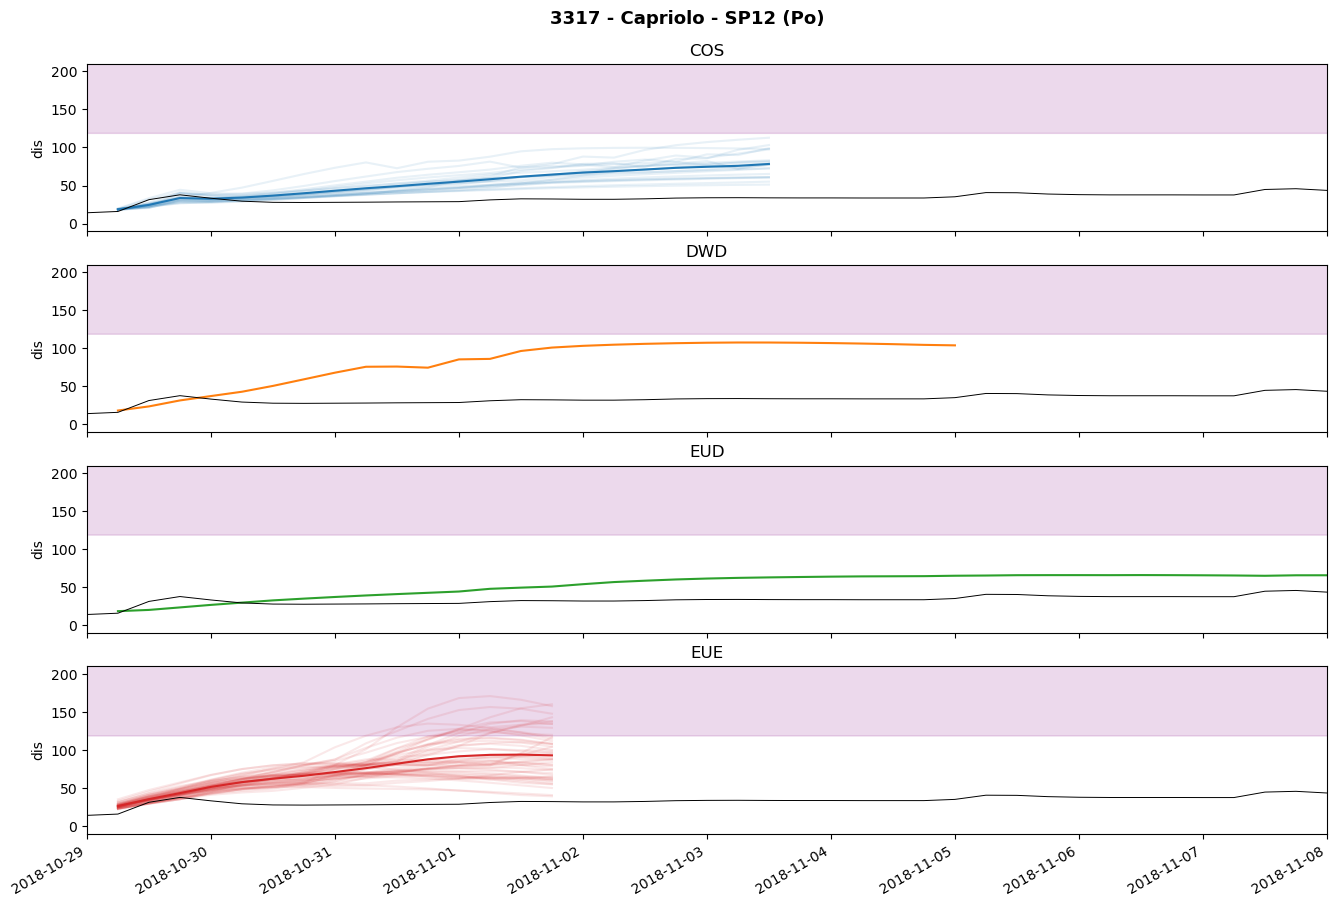

In [66]:
forecast = '2018102900'

# plot one forecast
fig, ax = plt.subplots(nrows=len(models), figsize=(16, 10), sharex=True, sharey=True)
xmin, xmax = datetime(2100, 1, 1), datetime(1900, 1, 1)
for i, model in enumerate(['COS', 'DWD', 'EUD', 'EUE']):
    file = [file for file in files[model] if forecast in file][0]
    da = xr.open_dataarray(file)
    if 'member' in da.dims:
        for member in da.member:
            da.sel(stations=stn, member=member).plot(ax=ax[i], color=f'C{i}', alpha=.1)
        da.sel(stations=stn).mean(['member']).plot(ax=ax[i], color=f'C{i}', label=model)
    else:
        da.sel(stations=stn).plot(ax=ax[i], color=f'C{i}', label=model)
    ax[i].plot(reanalysis[stn], 'k', lw=.7)
    ax[i].fill_between(reanalysis.index, Q5, 10000, color='purple', alpha=.15)
    ax[i].set(title=model, xlabel='')

start = datetime.strptime(forecast, '%Y%m%d%H')
end = start + timedelta(days=10)
magnitude = len(str(int(reanalysis[stn].max()))) - 1
ymax = np.ceil(reanalysis[stn].max() / 10**(magnitude)) * 10**magnitude + 10**(magnitude - 1)
ymin = - 10**(magnitude - 1)
ax[i].set(xlim=(start, end), ylim=(ymin, ymax))

fig.text(.5, .92, '{0} - {1} ({2})'.format(stn, *stations.loc[int(stn), ['StationName', 'Catchment']]),
         fontsize=13, fontweight='bold', horizontalalignment='center');

### Several forecast from one model

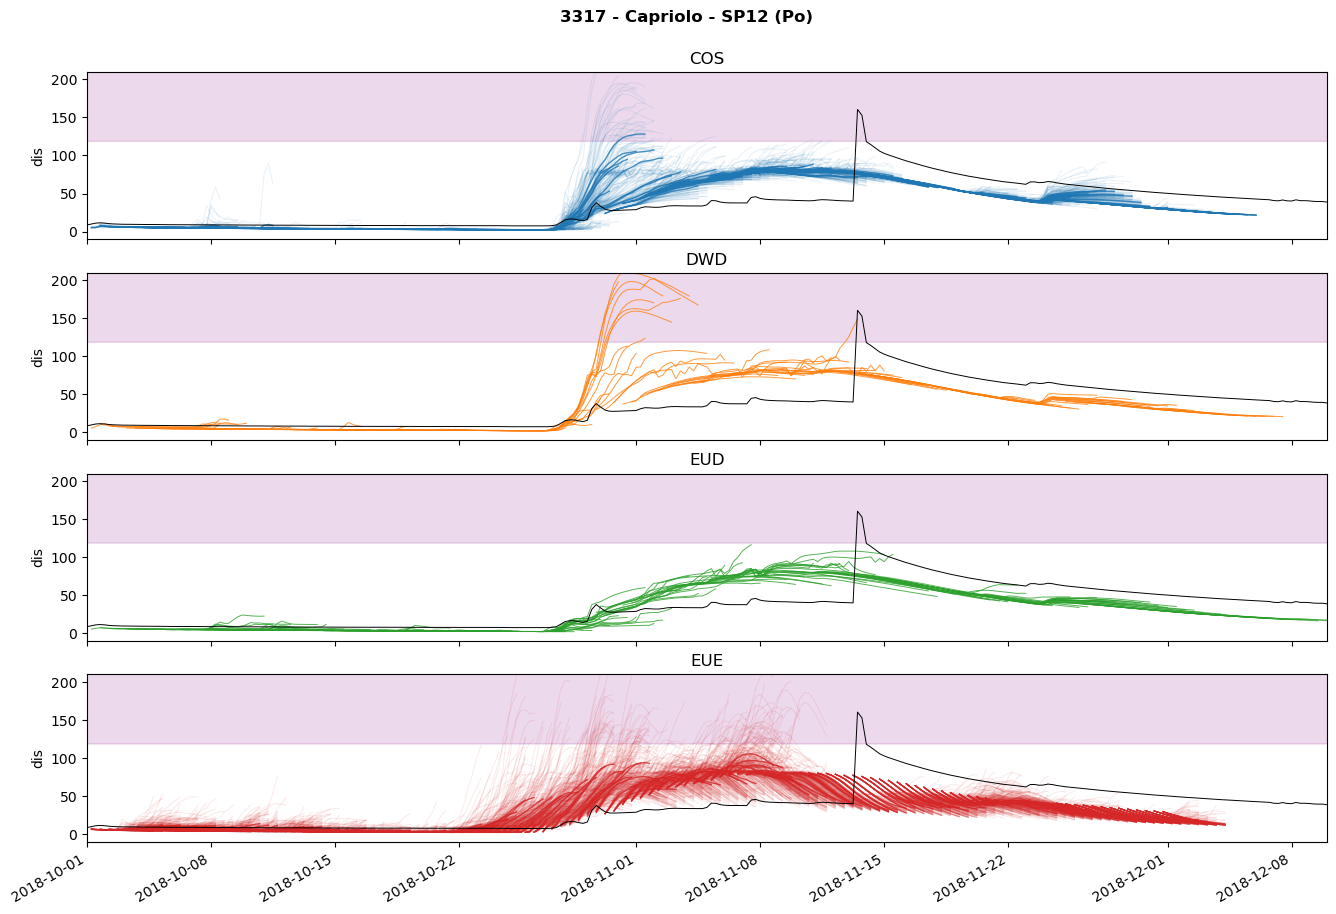

In [67]:
models = ['COS', 'DWD', 'EUD', 'EUE']

data = {}
fig, ax = plt.subplots(nrows=len(models), figsize=(16, 2.5 * len(models)), sharex=True, sharey=True)
for i, model in enumerate(models):
    files_sel = [file for file in files[model] if ('201810' in file) or ('201811' in file)]
    for file in files_sel:
        da = xr.open_dataarray(file)
        data[model] = da
        if 'member' in da.dims:
            for member in da.member:
                da.sel(stations=stn, member=member).plot(ax=ax[i], color=f'C{i}', lw=.7, alpha=.1)
            da.sel(stations=stn).mean(['member']).plot(ax=ax[i], color=f'C{i}', lw=1, alpha=.8, label=model)
        else:
            da.sel(stations=stn).plot(ax=ax[i], color=f'C{i}', lw=.7, alpha=.8, label=model)
        ax[i].set(title=model, xlabel='')
    ax[i].plot(reanalysis[stn], 'k', lw=.7)
    ax[i].fill_between(reanalysis.index, Q5, 10000, color='purple', alpha=.15)
    
magnitude = len(str(int(reanalysis[stn].max()))) - 1
ymax = np.ceil(reanalysis[stn].max() / 10**(magnitude)) * 10**magnitude + 10**(magnitude - 1)
ymin = - 10**(magnitude - 1)
ax[i].set(xlim=(datetime(2018, 10, 1), datetime(2018, 12, 10)), ylim=(ymin, ymax))    

fig.text(.5, .93, '{0} - {1} ({2})'.format(stn, *stations.loc[int(stn), ['StationName', 'Catchment']]),
         fontsize=12, fontweight='bold', horizontalalignment='center');

## Process exceedance

## Compute formal notifications

* One probabilistic forecast (_EUE_ or _COSMO_) exceeds Q5:
    * With a probability of exceedance $\geq 30 \%$
    * In 3 consecutive forecasts
* One deterministic forecasts (_EUD_ or _DWD_) exceeds Q5
* Catchment area $\geq 2000 km^2$
* Lead time $\geq 48 h$

### Reforecast

In [56]:
fore_exc = {model: compute_exceedance(files[model], stn, Q5) for model in models}

In [57]:
notifications = compute_notifications(fore_exc)

### Reanalysis

In [58]:
# Compute exceedance
rea_exc = (reanalysis[stn] >= Q5).astype(int)

In [59]:
# check if there was an event in each of the forecast windows
events = []
for forecast in notifications.forecast.values:
    start = forecast
    end = start + np.timedelta64(10, 'D')
    events.append(rea_exc[start:end].any())
    
events = xr.DataArray(events, dims='forecast', coords={'forecast': notifications.forecast})

### Skill

In [60]:
cm = confusion_matrix(events, notifications)
cm

array([[469,   0],
       [ 21,   0]], dtype=int64)

In [61]:
precision = cm[1, 1] / cm[:,1].sum()
recall = cm[1, 1] / cm[1,:].sum()
recall, precision

C:\Users\casadje\AppData\Local\Temp\ipykernel_11688\70369200.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cm[1, 1] / cm[:,1].sum()


(0.0, nan)

In [62]:
2 * precision * recall / (precision + recall)

nan

In [63]:
f1_score(events, notifications)

0.0